In [105]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
#from tqdm.notebook import tqdm

In [106]:
data = pd.read_csv('data_preprocessed.csv')

In [107]:
data.head()

,0,1,2,3,4,5,6,7,8
0,-0.694779,-0.723093,-1.009129,-1.431771,0.354952,0.003363,0.00874,1.328773,No
1,-0.694779,-0.723093,0.990954,0.417145,-0.683660,1.421794,0.00874,-1.343201,No
2,-0.694779,-0.723093,-1.009129,0.516390,0.435589,0.003363,0.00874,-0.452543,No
3,1.439306,-0.723093,0.990954,0.444561,-0.294177,-1.415068,0.00874,0.438115,No
4,-0.694779,-0.723093,-1.009129,-1.063517,0.236492,1.421794,0.00874,-0.452543,No


In [108]:
y = pd.DataFrame(data['8'])
X = data.drop(['8'],axis=1)

In [109]:
mapping = {
        'Yes': 1,
        'No': 0,
    }
y = y['8'].replace(mapping)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [111]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: 8, dtype: int64

In [112]:
X.head()

,0,1,2,3,4,5,6,7
0,-0.694779,-0.723093,-1.009129,-1.431771,0.354952,0.003363,0.00874,1.328773
1,-0.694779,-0.723093,0.990954,0.417145,-0.683660,1.421794,0.00874,-1.343201
2,-0.694779,-0.723093,-1.009129,0.516390,0.435589,0.003363,0.00874,-0.452543
3,1.439306,-0.723093,0.990954,0.444561,-0.294177,-1.415068,0.00874,0.438115
4,-0.694779,-0.723093,-1.009129,-1.063517,0.236492,1.421794,0.00874,-0.452543


In [113]:
def oversampler_choice(x):
    global X_train, y_train
    if x=="ros":
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_sample(X_train, y_train)
        print("Random Oversampler: ", y.value_counts())
    elif x=="smote":
        smote = SMOTE()
        X_train, y_train= smote.fit_sample(X_train, y_train)
        print("SMOTE: ", y_train.value_counts())
    elif x == "ada":
        ada = ADASYN(random_state=42)
        X_train, y_train = ada.fit_sample(X_train, y_train)
        print("ADASYN: ", y_train.value_counts())
    else:
        print ("Input should be ros, smote or ada")

In [114]:
#Choose oversampler. Random Oversampler: "ros", SMOTE: "smote", ADASYN: "ada"
oversampler_choice("smote")


SMOTE:  0    1431
1    1431
Name: 8, dtype: int64


In [115]:
# Undersample and plot imbalanced dataset with Tomek Links
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import TomekLinks
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# define the undersampling method
undersample = TomekLinks()
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)
# scatter plot of examples by class label

Counter({0: 2381, 1: 150})
Counter({0: 1431, 1: 1425})


In [116]:
#for label, _ in counter.items():
#	row_ix = where(y == label)[0]
#	pyplot.scatter(X, y, label=str(label))
#pyplot.legend()
#pyplot.show()

In [117]:
#Kfold validation
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))


results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.940736 (0.016098)
KNN: 0.934811 (0.014267)
CART: 0.880279 (0.017624)
NB: 0.940736 (0.016098)
RFC: 0.938366 (0.015522)


In [118]:
#split into train/test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [119]:
def model_predictions(x):
    global X_train, X_test, y_train, y_test
    if x == "logistic":
        model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        model.fit(X_train, y_train)
        print("Logistic:")
        predictions =  model.predict(X_test)
    elif x == "knn":
        model = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
        model.fit(X_train, y_train)
        print("KNN:")
        predictions = model.predict(X_test)
    elif x=="decision_tree":
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        print("Decision Tree:")
        predictions = model.predict(X_test)
    elif x=="random_forest":
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        print ("Random Forest:")
        predictions = model.predict(X_test)
    else:
        print ("Choose logistic, knn, decision_tree or random_forest")   
    
    print("The accuracy of the model on test set is: ", accuracy_score(y_test, predictions))
    print("Kappa: ", cohen_kappa_score(y_test, predictions))       
    #print("ROC-AUC score: ", roc_auc_score(y_test, predictions)) #should be as high as possible 0-1
    print("Accuracy score: ", accuracy_score(y_test, predictions)) #percent correct 0-1
    #print("F1 score: ", f1_score(y_test, predictions)) #should be as high as possible 0-1      
    print ("R squared: ", r2_score(y_test, predictions))
    print ("MSE: ", mean_squared_error(y_test, predictions))
    print ("RMSE: ", math.sqrt(mean_squared_error(y_test, predictions)))
    print ("MAE: ", mean_absolute_error(y_test, predictions))
    print ("Confusion Matrix - raw:")
    plot_confusion_matrix(model, X_test, y_test, cmap = "GnBu")
    plt.show() 
    print ("Confusion Matrix - normalised:")
    plot_confusion_matrix(model, X_test, y_test, normalize='all', cmap = "GnBu")
    plt.show() 

Random Forest:
The accuracy of the model on test set is:  0.914116485686081
Kappa:  0.0441634220144681
Accuracy score:  0.914116485686081
R squared:  -0.47253132832080214
MSE:  0.08588351431391905
RMSE:  0.2930588922280282
MAE:  0.08588351431391905
Confusion Matrix - raw:


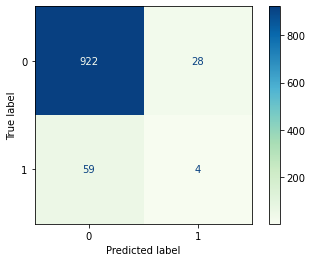

Confusion Matrix - normalised:


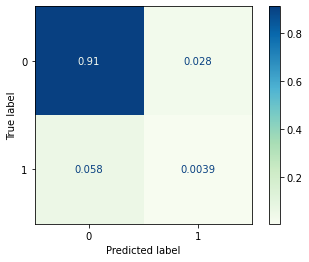

In [120]:
#choose which model to run. Logistic Regression: "logistic", K Nearest Neighbours: "knn", 
#Decision Tree: "decision_tree", Random Forest: "random_forest"

model_predictions("random_forest")

In [121]:
X_train.columns = ['reward', 'mailer_type', 'mailer_type','income_level','credit_rating','household_size','average_balance','range']

In [122]:
X_train.head()

,reward,mailer_type,mailer_type,income_level,credit_rating,household_size,average_balance,range
0,-0.694779,-0.723093,0.990954,1.261127,-0.607617,-1.415068,0.008740,2.219431
1,-0.694779,1.382947,-1.009129,-0.053629,1.189053,1.421794,0.008740,-2.233859
2,-0.694779,-0.723093,-1.009129,1.575597,-3.147242,1.421794,-1.220186,0.438115
3,1.439306,-0.723093,-1.009129,-0.313839,0.947622,-1.415068,0.008740,0.438115
4,-0.694779,1.382947,0.990954,0.849060,-0.650925,0.003363,-1.220186,0.438115


In [123]:
y_train = pd.DataFrame(y_train)

In [124]:
y_train.columns = ['offer_accepted']

In [125]:
y_train.head()

,offer_accepted
0,0
1,0
2,0
3,0
4,0


In [128]:
X_train.columns

Index(['reward', 'mailer_type', 'mailer_type', 'income_level', 'credit_rating',
       'household_size', 'average_balance', 'range'],
      dtype='object')

feature importance

Feature: 0, Score: 0.08418
Feature: 1, Score: 0.04271
Feature: 2, Score: 0.08131
Feature: 3, Score: 0.13220
Feature: 4, Score: 0.13936
Feature: 5, Score: 0.16043
Feature: 6, Score: 0.20597
Feature: 7, Score: 0.15385


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

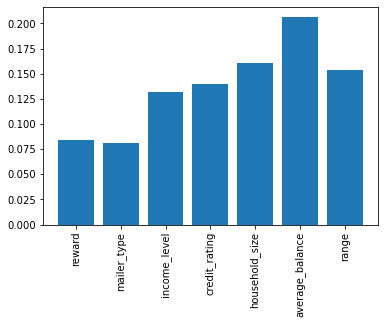

In [144]:

# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
#X_train, y_train = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in X_train], importance)
plt.xticks(rotation='vertical')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pydotplus 
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pydotplus
import warnings
from glob import glob
from IPython.display import display, Image
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
#from graphviz import render
#render('dot', 'png', 'fname.dot')

def save_decision_trees_as_png(clf, iteration, feature_name, target_name):
    file_name = 'client_' + str(iteration) + '.png'
    dot_data= export_graphviz(
        clf,
        out_file=None,
        feature_names = feature_names,
        class_names = target_name,
        rounded = True,
        proportion= False,
        precision = 2,
        filled = True,
    )
    #graph = pydotplus.graph_from_dot_data(dot_data)
    graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
    graph.write_png('C:\\Users\\segre\\OneDrive\\Documents\\'+file_name)
    print('Decision Tree {} saved as png file'.format(iteration + 1))

In [ ]:
iris = load_iris()
feature_names = iris.feature_names
target_names = iris.target_names

In [ ]:
model = RandomForestClassifier(n_estimators=5)
model.fit(iris.data, iris.target)

In [ ]:
model.estimators_

In [ ]:
model.estimators_[0]

In [ ]:
len(model.estimators_)

In [ ]:
for i in range(len(model.estimators_)):
    save_decision_trees_as_png(model.estimators_[i], i, feature_names, target_names)

In [ ]:
images = [ PIL.Image.open(f) for f in glob('./*.png') ]

In [ ]:
images

In [ ]:
for im in images:
    display(Image(filename=im.filename, retina=True))

In [ ]:
feature_names

In [ ]:
d_tree = tree.DecisionTreeClassifier()
d_tree.fit(X_train, y_train)

dot_data = tree.export_graphviz(d_tree,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  

from IPython.display import Image 
Image(graph.create_png()) 

def firth_logit(X,y,num_iter=100,learning_rate=0.01):
    #Initialize weights
    weights = np.ones(X.shape[1])
    print (weights)
    #Define get_predictions function
    def get_predictions(X,weights):
        z = np.dot(X,weights)
        print (z)
        y_pred =  1/(1 + np.exp(-z))
        print (y_pred)
    #Perform gradient descent
    for i in range(num_iter):
        y_pred = get_predictions(X,weights)
        print (y_pred)
        #Calculate Fisher information matrix
        Xt = X.transpose()
        W = np.diag(y_pred*(1-y_pred))
        I = np.linalg.multi_dot([Xt,W,X])
        #Find diagonal of Hat Matrix
        sqrtW = W**0.5
        H = np.linalg.multi_dot([sqrtW,X,np.linalg.inv(I),Xt,sqrtW])
        hat_diag = np.diag(H)
        #Calculate U_star
        U_star = np.matmul((y -y_pred + hat_diag*(0.5 - y_pred)),X)
        #Update weights
        weights += np.matmul(np.linalg.inv(I),U_star)*learning_rate
        #Get final predictions
    y_pred =  get_predictions(X,weights)
    return y_pred

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier


X, y = make_blobs(centers=[[0, 0], [1, 1]], random_state=61526, n_samples=50)

def plot_forest(max_depth=1):
    plt.figure()
    ax = plt.gca()
    h = 0.02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    if max_depth != 0:
        forest = RandomForestClassifier(n_estimators=20, max_depth=max_depth,
                                        random_state=1).fit(X, y)
        Z = forest.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4)
        ax.set_title("max_depth = %d" % max_depth)
    else:
        ax.set_title("data set")
    ax.scatter(X[:, 0], X[:, 1], c=np.array(['b', 'r'])[y], s=60)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def plot_forest_interactive():
    from IPython.html.widgets import interactive, IntSlider
    slider = IntSlider(min=0, max=8, step=1, value=0)
    return interactive(plot_forest, max_depth=slider)

plot_forest_interactive()